In [1]:
this_notebook_name = "BreastSegmentationStudy-TF2"

# Update this folder name for your computer

local_data_folder = "/Usersß/Josh Ehrlich/Courses/CISC881/Project/data"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

import numpy as np

ultrasound_size = 128
num_classes = 2
num_epochs = 200
batch_size = 64
max_learning_rate = 0.02
min_learning_rate = 0.000001
regularization_rate = 0.0001
filter_multiplier = 15
class_weights = np.array([0.15, 0.85])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

'''
Provide NxM numpy array to schedule cross validation
N rounds of validation will be performed, leaving out M patients in each for validation data
All values should be valid patient IDs, or negative. Negative values are ignored.

Example 1: a leave-one-out cross validation with 3 patients would look like this:
validation_schedule_patient = np.array([[0],[1],[2]])

Example 2: a leave-two-out cross validation on 10 patients would look like this:
validation_schedule_patient = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])

Example 3: leave-one-out cross validation with 3 patients, then training on all available data (no validation):
validation_schedule_patient = np.array([[0],[1],[2],[-1]])
'''
validation_schedule_patient = np.array([ [19,22,29,32], [20,23,27,30]])
                                        #to complete next time:[0,1,2,3], [7,11,13,18], [9,14,21,31]

# Uncomment for faster debugging

roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01, 0.001]
num_epochs = 200

Save timestamp: 2021-02-12_19-44-01


In [2]:
import os
from random import sample
from pathlib import Path

from ipywidgets import IntProgress
from IPython.display import display, HTML

import diskcache
import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import ultrasound_batch_generator as generator
import evaluation_metrics

from girder_apikey import girder_apikey

In [3]:
# Import aigt modules

import sys
parent_folder = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(parent_folder)

import Models.segmentation_unet as unet
import utils

In [4]:
# Creating standard folders to save data and logs

data_arrays_fullpath, notebooks_save_fullpath, results_save_fullpath, models_save_fullpath, val_data_fullpath =\
    utils.create_standard_project_folders(local_data_folder)

In [5]:
# Fetching Girder data

girder_url = "https://pocus.cs.queensu.ca/api/v1"
data_csv_file = "BreastGirder.csv"
girder_key = girder_apikey

ultrasound_arrays_by_patients, segmentation_arrays_by_patients =\
    utils.load_girder_data(data_csv_file, data_arrays_fullpath, girder_url, girder_key)
    
n_patients = len(ultrasound_arrays_by_patients)

for i in range(n_patients):
    print("Patient {} has {} ultrasounds and {} segmentations".format(
        i, ultrasound_arrays_by_patients[i].shape[0], segmentation_arrays_by_patients[i].shape[0]))

Patient 0 has 379 ultrasounds and 379 segmentations
Patient 1 has 292 ultrasounds and 292 segmentations
Patient 2 has 426 ultrasounds and 426 segmentations
Patient 3 has 418 ultrasounds and 418 segmentations
Patient 4 has 442 ultrasounds and 442 segmentations
Patient 5 has 224 ultrasounds and 224 segmentations
Patient 6 has 272 ultrasounds and 272 segmentations
Patient 7 has 288 ultrasounds and 288 segmentations
Patient 8 has 175 ultrasounds and 175 segmentations
Patient 9 has 113 ultrasounds and 113 segmentations
Patient 10 has 237 ultrasounds and 237 segmentations
Patient 11 has 180 ultrasounds and 180 segmentations
Patient 12 has 5 ultrasounds and 5 segmentations
Patient 13 has 402 ultrasounds and 402 segmentations
Patient 14 has 295 ultrasounds and 295 segmentations
Patient 15 has 331 ultrasounds and 331 segmentations
Patient 16 has 145 ultrasounds and 145 segmentations
Patient 17 has 253 ultrasounds and 253 segmentations
Patient 18 has 158 ultrasounds and 158 segmentations
Patient

In [6]:
# Prepare validation rounds

if np.max(np.max(validation_schedule_patient)) > (n_patients - 1):
    raise Exception("Patient ID cannot be greater than {}".format(n_patients - 1))

num_validation_rounds = len(validation_schedule_patient)
print("Planning {} rounds of validation".format(num_validation_rounds))
for i in range(num_validation_rounds):
    print("Validation on patients {} in round {}".format(validation_schedule_patient[i], i))

Planning 2 rounds of validation
Validation on patients [19 22 29 32] in round 0
Validation on patients [20 23 27 30] in round 1


Timestamp for saved files: 2021-02-12_19-44-01

Training parameters
Number of epochs:    200
Step size maximum:   0.02
Step size decay:     9.9995e-05
Batch size:          64
Regularization rate: 0.0001

Saving validation predictions in: /Usersß/Josh Ehrlich/Courses/CISC881/Project/data\PredictionsValidation
Saving models in:                 /Usersß/Josh Ehrlich/Courses/CISC881/Project/data\SavedModels

*** Leave-one-out round # 0
    Training on 6580 images, validating on 738 images...
[<tf.Tensor 'batch_normalization_7/cond/Identity:0' shape=(None, 16, 16, 128) dtype=float32>]
[<tf.Tensor 'batch_normalization_5/cond/Identity:0' shape=(None, 32, 32, 64) dtype=float32>]
[<tf.Tensor 'batch_normalization_3/cond/Identity:0' shape=(None, 64, 64, 32) dtype=float32>]
[<tf.Tensor 'batch_normalization_1/cond/Identity:0' shape=(None, 128, 128, 16) dtype=float32>]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)

  Training time: 1 day, 3:08:14.422832
(738, 128, 128, 1)

Total round time:  1 day, 3:08:25.739636


*** Leave-one-out round # 1
    Training on 6689 images, validating on 629 images...
[<tf.Tensor 'batch_normalization_27/cond/Identity:0' shape=(None, 16, 16, 128) dtype=float32>]
[<tf.Tensor 'batch_normalization_25/cond/Identity:0' shape=(None, 32, 32, 64) dtype=float32>]
[<tf.Tensor 'batch_normalization_23/cond/Identity:0' shape=(None, 64, 64, 32) dtype=float32>]
[<tf.Tensor 'batch_normalization_21/cond/Identity:0' shape=(None, 128, 128, 16) dtype=float32>]
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2

  Training time: 1 day, 3:37:02.949622
(629, 128, 128, 1)

Total round time:  1 day, 3:37:12.528792


Total training time:   2 days, 6:45:53.962154


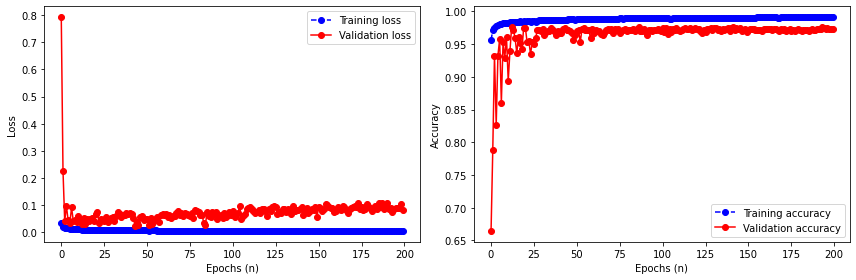

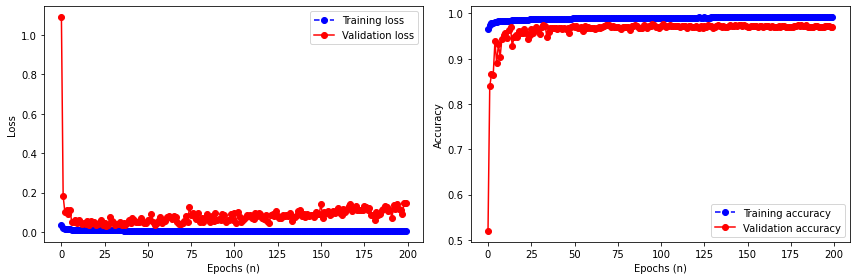

In [7]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Perform validation rounds

for val_round_index in range(num_validation_rounds):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0,
         ultrasound_arrays_by_patients[0].shape[1],
         ultrasound_arrays_by_patients[0].shape[2],
         ultrasound_arrays_by_patients[0].shape[3]])
    
    train_segmentation_data = np.zeros(
        [0,
         segmentation_arrays_by_patients[0].shape[1],
         segmentation_arrays_by_patients[0].shape[2],
         segmentation_arrays_by_patients[0].shape[3]])
    
    val_ultrasound_data = np.zeros(
        [0,
         ultrasound_arrays_by_patients[0].shape[1],
         ultrasound_arrays_by_patients[0].shape[2],
         ultrasound_arrays_by_patients[0].shape[3]])
    
    val_segmentation_data = np.zeros(
        [0,
         segmentation_arrays_by_patients[0].shape[1],
         segmentation_arrays_by_patients[0].shape[2],
         segmentation_arrays_by_patients[0].shape[3]])
    
    for patient_index in range(n_patients):
        if patient_index not in validation_schedule_patient[val_round_index]:
            train_ultrasound_data = np.concatenate((train_ultrasound_data,
                                                    ultrasound_arrays_by_patients[patient_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data,
                                                      segmentation_arrays_by_patients[patient_index]))
        else:
            val_ultrasound_data = np.concatenate((val_ultrasound_data,
                                                 ultrasound_arrays_by_patients[patient_index]))
            val_segmentation_data = np.concatenate((val_segmentation_data,
                                                   segmentation_arrays_by_patients[patient_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-one-out round # {}".format(val_round_index))
    print("    Training on {} images, validating on {} images...".format(n_train, n_val))
    
    val_segmentation_data_onehot = tf.keras.utils.to_categorical(val_segmentation_data, num_classes)
    
    # Create and train model
    
    model = unet.segmentation_unet(ultrasound_size, num_classes, filter_multiplier, regularization_rate)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
        loss=unet.weighted_categorical_crossentropy(class_weights),
        metrics=["accuracy"]
    )
    '''
    #----------------------------------------------------------------------------
    import os
    import sys
    import datetime
    from random import sample
    from pathlib import Path
    import girder_client
    import matplotlib.pyplot as plt
    import pandas as pd
    import tensorflow as tf
    import numpy as np

    from Spine.ultrasound_batch_generator import train_preprocess, train_preprocess_with_maps, generate_weight_maps
    from Spine import evaluation_metrics

    from Spine.models import (
        new_unet,
        weighted_categorical_crossentropy,
        weighted_categorical_crossentropy_with_maps,
    )
    import utils


    batch_size=128, 
    num_epochs=100, 
    sagittal_only=False, 
    num_frames=1, 
    with_maps=False, 
    learning_rate=0.002,
    lr_decay=False,
    dropout=0.0,
    use_attention=True,
    num_layers=5,
    filters=16,
    use_batch_norm=True,
    load_from_save=False,

    ultrasound_size = 128
    batch_size = 128
    num_classes = 2
    min_learning_rate = 0.00001
    class_weights = np.array([0.1, 0.9])
    learning_rate_decay = (0.002-0.00001) / 100
    num_epochs = 100

    model = new_unet(
                input_size = ultrasound_size,
                num_classes=num_classes,
                num_channels=num_frames,
                use_batch_norm=use_batch_norm,
                upsample_mode="deconv",  # 'deconv' or 'simple'
                dropout=dropout,
                dropout_type="spatial",
                use_attention=use_attention,
                filters=filters,
                num_layers=num_layers,
                output_activation="softmax",
            )

    learning_rate = 0.002
    loss_func = weighted_categorical_crossentropy(class_weights)
    
    preprocess_func = train_preprocess
    print(learning_rate, learning_rate_decay)
    model.compile(
                optimizer=tf.keras.optimizers.Adam(
                    lr=learning_rate, decay=learning_rate_decay
                ),
                loss=loss_func,
                metrics=["accuracy", evaluation_metrics.jaccard_coef, evaluation_metrics.dice_coef],
            )

#-----------------------------------------------------
    '''
    
    model.summary() #prints the structure of the neural network. If you change the unet,
    #print this so yuo can see it.

    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    print("TRAINING LOG",training_generator)
    if n_val > 0:
        training_log = model.fit_generator(
            training_generator,
            validation_data=(val_ultrasound_data, val_segmentation_data_onehot),
            epochs=num_epochs,
            verbose=0)
    else:
        training_log = model.fit_generator(training_generator, epochs=num_epochs, verbose=0)
    
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    if n_val > 0:
        axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    if n_val > 0:
        axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['accuracy'], 'bo--')
    if n_val > 0:
        axes[1].plot(training_log.history['val_accuracy'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    if n_val > 0:
        axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Archive trained model with unique filename based on notebook name and timestamp
    model_file_name = this_notebook_name + "_model-" + str(val_round_index) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)

    # Predict on validation data
    
    if n_val > 0:
        print(val_ultrasound_data.shape)
        y_pred_val  = model.predict(val_ultrasound_data)

        # Saving predictions for further evaluation

        val_prediction_filename = save_timestamp + "_prediction_" + str(val_round_index) + ".npy"
        val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
        np.save(val_prediction_fullname, y_pred_val)
        
        # Validation results

        vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
            roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)

        val_fuzzy_metrics[val_round_index] = evaluation_metrics.compute_evaluation_metrics(
            y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)

        val_best_metrics[val_round_index]    = vali_metrics_dicts[vali_best_threshold_index]
        val_aurocs[val_round_index]          = vali_area
        val_best_thresholds[val_round_index] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [8]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []
  
for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_validation_rounds):
    if i in val_best_metrics.keys():
        results_df.loc[i] = [
            val_aurocs[i],
            val_best_thresholds[i],
            val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.RECALL],
            val_best_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.RECALL],
            val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
        ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

Vali AUROC  Vali best thresh  Vali best TP  Vali best FP  Vali best recall  \
0    0.771716             0.001      0.787247      0.083344          0.787247   
1    0.649450             0.001      0.660093      0.046565          0.660093   

   Vali best precis  Vali fuzzy recall  Vali fuzzy precis  Vali fuzzy Fscore  
0          0.221071           0.438922           0.523995           0.477700  
1          0.334309           0.271938           0.615000           0.377122


Averages


Vali AUROC           0.710583
Vali best thresh     0.001000
Vali best TP         0.723670
Vali best FP         0.064955
Vali best recall     0.723670
Vali best precis     0.277690
Vali fuzzy recall    0.355430
Vali fuzzy precis    0.569497
Vali fuzzy Fscore    0.427411
dtype: float64

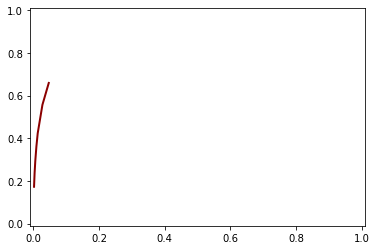

In [9]:
# Print the last ROC curve for visual verification that we catch the optimal point

n = len(roc_thresholds)

roc_x = np.zeros(n)
roc_y = np.zeros(n)

for i in range(n):
    roc_x[i] = vali_metrics_dicts[i][evaluation_metrics.FALSE_POSITIVE_RATE]
    roc_y[i] = vali_metrics_dicts[i][evaluation_metrics.SENSITIVITY]
    # print("Threshold = {0:4.2f}  False pos rate = {1:4.2f}  Sensitivity = {2:4.2f}"
    #       .format(roc_thresholds[i], roc_x[i], roc_y[i]))

    
plt.figure()
plt.ylim(-0.01, 1.01)
plt.xlim(-0.01, 1.01)
plt.plot(roc_x, roc_y, color='darkred', lw=2)

In [10]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: /Usersß/Josh Ehrlich/Courses/CISC881/Project/data\SavedResults\BreastSegmentationStudy-TF2_2021-02-12_19-44-01.csv


(629, 128, 128, 1)
Showing image slices for patient 20 : [63, 94, 72, 121, 130, 2, 64, 111, 26, 46, 12, 67, 132, 49, 61, 90, 65, 106, 14, 100]
Showing image slices for patient 23 : [347, 185, 215, 228, 345, 176, 186, 335, 301, 237, 316, 288, 181, 354, 331, 261, 194, 225, 205, 153]
Showing image slices for patient 27 : [364, 459, 405, 464, 426, 397, 483, 416, 430, 392, 447, 401, 423, 409, 378, 458, 422, 445, 451, 379]
Showing image slices for patient 30 : [494, 488, 571, 626, 568, 529, 582, 486, 484, 533, 485, 574, 507, 516, 493, 499, 549, 561, 625, 523]


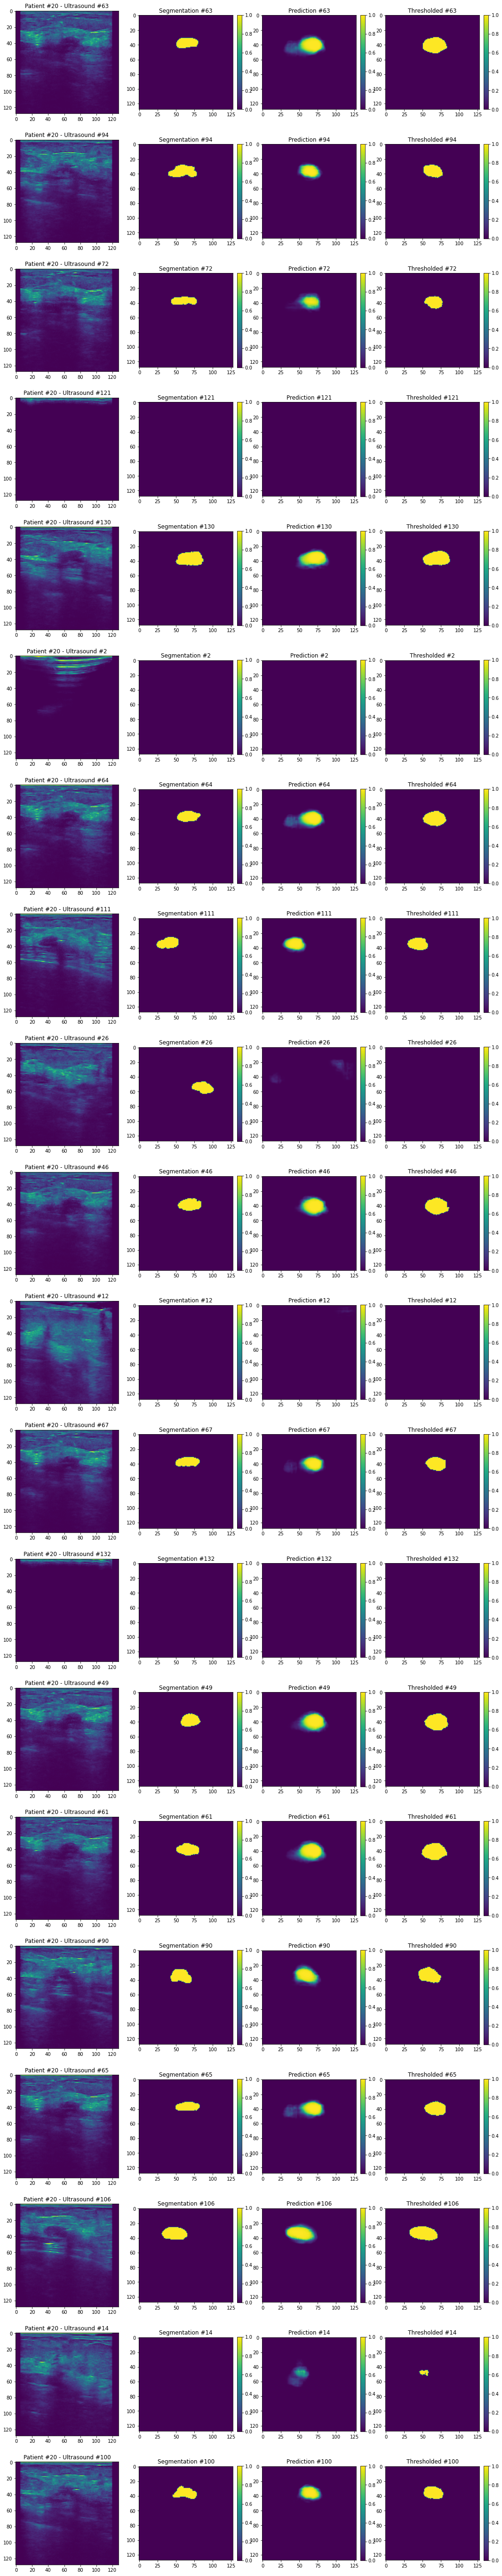

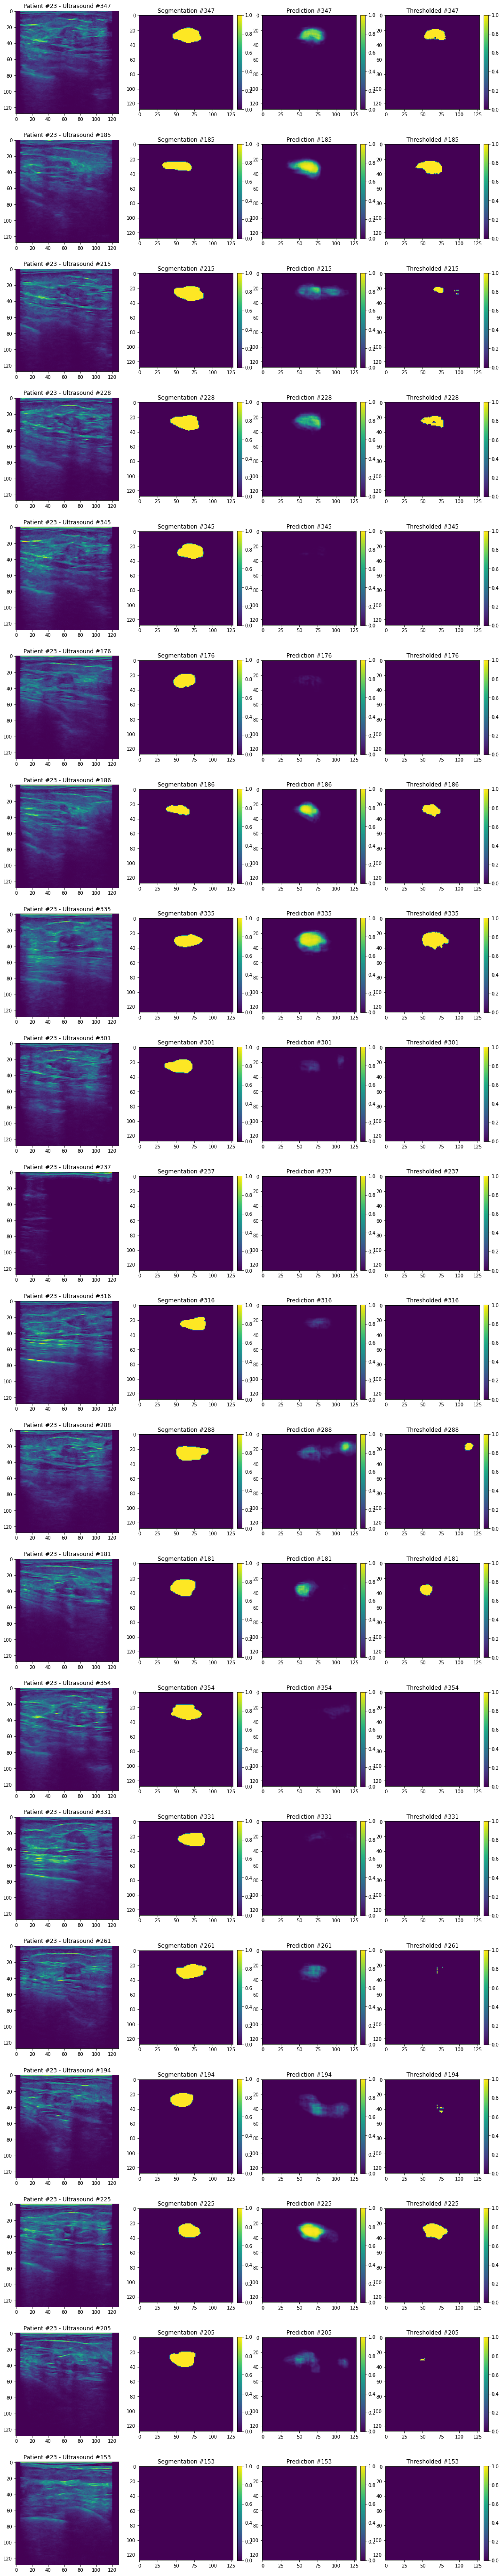

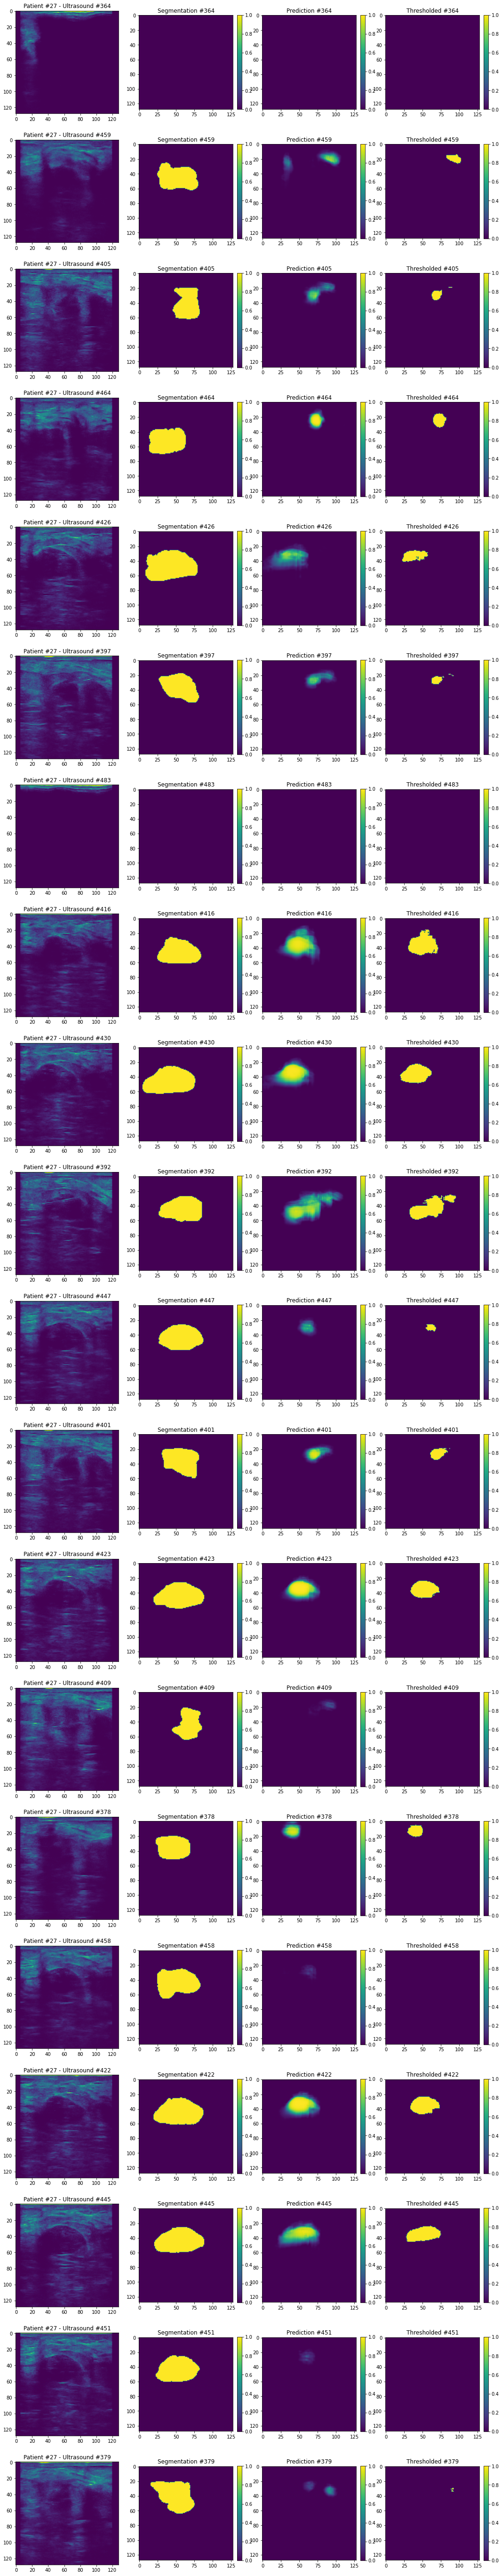

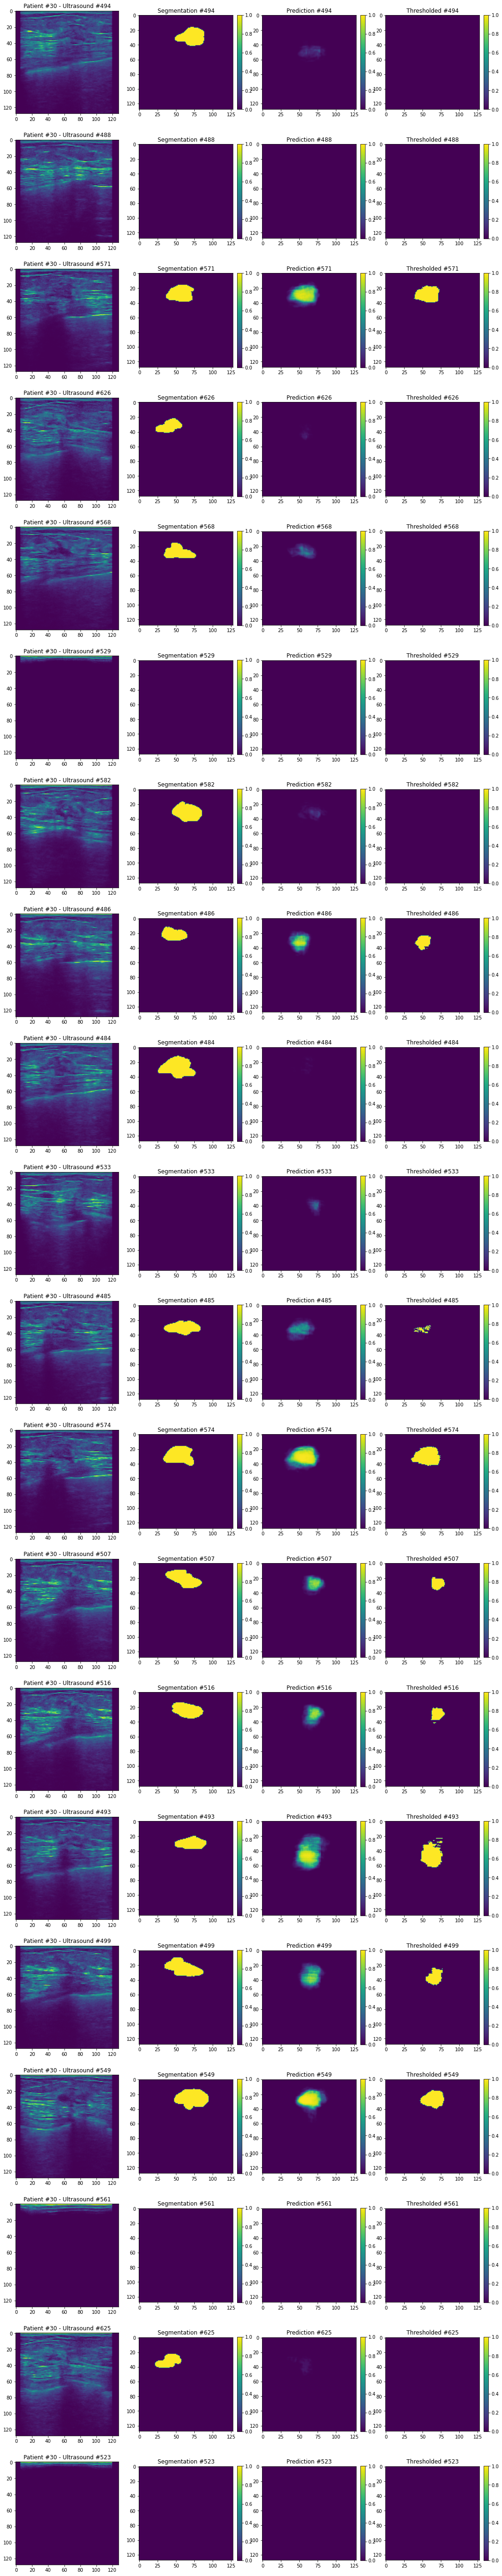

In [11]:
# Display sample results

# determine the available ultrasounds in the last round of validation
last_round = validation_schedule_patient[-1]
print(val_ultrasound_data.shape)
prev_vali = 0

#20: [63, 94, 72, 121, 130, 2, 64, 111, 26, 46, 12, 67, 132, 49, 61, 90, 65, 106, 14, 100]
#23: [347, 185, 215, 228, 345, 176, 186, 335, 301, 237, 316, 288, 181, 354, 331, 261, 194, 225, 205, 153]
#27: [364, 459, 405, 464, 426, 397, 483, 416, 430, 392, 447, 401, 423, 409, 378, 458, 422, 445, 451, 379]
#30: [494, 488, 571, 626, 568, 529, 582, 486, 484, 533, 485, 574, 507, 516, 493, 499, 549, 561, 625, 523]
count = 0
patientNumber = [20, 23, 27, 30]
sample_indices = [[63, 94, 72, 121, 130, 2, 64, 111, 26, 46, 12, 67, 132, 49, 61, 90, 65, 106, 14, 100], [347, 185, 215, 228, 345, 176, 186, 335, 301, 237, 316, 288, 181, 354, 331, 261, 194, 225, 205, 153], [364, 459, 405, 464, 426, 397, 483, 416, 430, 392, 447, 401, 423, 409, 378, 458, 422, 445, 451, 379], [494, 488, 571, 626, 568, 529, 582, 486, 484, 533, 485, 574, 507, 516, 493, 499, 549, 561, 625, 523]]
for j in range(len(last_round)):
    
    num_vali =  prev_vali + ultrasound_arrays_by_patients[last_round[j]].shape[0]
    num_show = 20
    if num_vali < num_show:
        num_show = 0
    num_col = 4

    indices = [i for i in range(prev_vali, num_vali)]
    #sample_indices = sample(indices, num_show)
    print("Showing image slices for patient", patientNumber[count], ":", sample_indices[count])
    #sample_indices = [prev_vali]
    
    # update
    prev_vali = num_vali
    threshold = 0.5
    
    fig = plt.figure(figsize=(18, num_show*5))
    for i in range(num_show):
        a0 = fig.add_subplot(num_show, num_col, i*num_col+1)
        img0 = a0.imshow(np.flipud(val_ultrasound_data[sample_indices[count][i], :, :, 0].astype(np.float32)))
        a0.set_title("Patient #{} - Ultrasound #{}".format(last_round[j], sample_indices[count][i]))
        a1 = fig.add_subplot(num_show, num_col, i*num_col+2)
        img1 = a1.imshow(np.flipud(val_segmentation_data_onehot[sample_indices[count][i], :, :, 1]), vmin=0.0, vmax=1.0)
        a1.set_title("Segmentation #{}".format(sample_indices[count][i]))
        c = fig.colorbar(img1, fraction=0.046, pad=0.04)
        a2 = fig.add_subplot(num_show, num_col, i*num_col+3)
        img2 = a2.imshow(np.flipud(y_pred_val[sample_indices[count][i], :, :, 1]), vmin=0.0, vmax=1.0)
        a2.set_title("Prediction #{}".format(sample_indices[count][i]))
        c = fig.colorbar(img2, fraction=0.046, pad=0.04)
        a3 = fig.add_subplot(num_show, num_col, i*num_col+4)
        img3 = a3.imshow((np.flipud(y_pred_val[sample_indices[count][i], :, :, 1]) > threshold), vmin=0.0, vmax=1.0)
        c = fig.colorbar(img3, fraction=0.046, pad=0.04)
        a3.set_title("Thresholded #{}".format(sample_indices[count][i]))
    count = count + 1

In [12]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [13]:

# Arrange results in tables

metric_labels = [
    'overall accuracy',
    'sensitivity-wrong',
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []
  
for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_validation_rounds):
    if i in val_best_metrics.keys():
        results_df.loc[i] = [
            val_best_metrics[i][evaluation_metrics.ACCURACY]*100,
            (val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE])/(val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE] + (1-val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE])),
            val_aurocs[i],
            val_best_thresholds[i],
            val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.RECALL],
            val_best_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.RECALL],
            val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
        ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)
'''

# Arrange results in tables

#metric_labels = [
#    "Acc",
#    "AUROC",
#    "best thresh",
#    "best TP",
#    "best FP",
#    "best recall",
#    "best precis",
#    "best dice",
#    "fuzzy recall",
#    "fuzzy precis",
#    "fuzzy Fscore"
#]

metric_labels = [
    "Overall Acc",
    "Image Classification Acc",
    "Img Classification TP",
    "Img Classification FP",
    "Img Classification FN",
    "Img Classification TN",
    "Img Classification Sensitivity (TP/(TP+FN))",
    "Img Classification Specificity (TN/(TN+FP))",
    "Img Classification Precision (TP/(TP+FP))",
    "Avg Center Distance",
    "Avg Prediction Overlap",
    "Avg Missed Prediction",
    "Dice"    
]
results_labels = []

for label in metric_labels:
    results_labels.append("Test " + label)

    
results_df = pd.DataFrame(columns = results_labels)

num_models = num_validation_rounds
test_best_metrics = val_best_metrics

for i in range(num_models):
    results_df.loc[i] = [
        test_best_metrics[i][evaluation_metrics.ACCURACY]*100,
        img_ACCs[i]*100,
        img_TPs[i],
        img_FPs[i],
        img_FNs[i],
        img_TNs[i],
        img_TPs[i]/(max(1,img_TPs[i]+img_FNs[i]))*100,
        img_TNs[i]/(max(1,img_TNs[i]+img_FPs[i]))*100,
        img_TPs[i]/(max(1,img_TPs[i]+img_FPs[i]))*100,
        totDistanceErrs[i],
        totSeg[i]*100,
        totMissed[i]*100,
        #test_aurocs[i],
        #test_best_thresholds[i],
        #test_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        #test_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        #test_best_metrics[i][evaluation_metrics.RECALL],
        #test_best_metrics[i][evaluation_metrics.PRECISION],
        test_best_metrics[i][evaluation_metrics.DICE]*100,
        #test_fuzzy_metrics[i][evaluation_metrics.RECALL],
        #test_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        #test_fuzzy_metrics[i][evaluation_metrics.FSCORE],
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
results_std_df = results_df.std()
display(results_means_df)

print("\STD")
display(results_std_df)'''

Vali overall accuracy  Vali sensitivity-wrong  Vali AUROC  \
0              91.288071                0.787247    0.771716   
1              94.339809                0.660093    0.649450   

   Vali best thresh  Vali best TP  Vali best FP  Vali best recall  \
0             0.001      0.787247      0.083344          0.787247   
1             0.001      0.660093      0.046565          0.660093   

   Vali best precis  Vali fuzzy recall  Vali fuzzy precis  Vali fuzzy Fscore  
0          0.221071           0.438922           0.523995           0.477700  
1          0.334309           0.271938           0.615000           0.377122


Averages


Vali overall accuracy     92.813940
Vali sensitivity-wrong     0.723670
Vali AUROC                 0.710583
Vali best thresh           0.001000
Vali best TP               0.723670
Vali best FP               0.064955
Vali best recall           0.723670
Vali best precis           0.277690
Vali fuzzy recall          0.355430
Vali fuzzy precis          0.569497
Vali fuzzy Fscore          0.427411
dtype: float64

'\n\n# Arrange results in tables\n\n#metric_labels = [\n#    "Acc",\n#    "AUROC",\n#    "best thresh",\n#    "best TP",\n#    "best FP",\n#    "best recall",\n#    "best precis",\n#    "best dice",\n#    "fuzzy recall",\n#    "fuzzy precis",\n#    "fuzzy Fscore"\n#]\n\nmetric_labels = [\n    "Overall Acc",\n    "Image Classification Acc",\n    "Img Classification TP",\n    "Img Classification FP",\n    "Img Classification FN",\n    "Img Classification TN",\n    "Img Classification Sensitivity (TP/(TP+FN))",\n    "Img Classification Specificity (TN/(TN+FP))",\n    "Img Classification Precision (TP/(TP+FP))",\n    "Avg Center Distance",\n    "Avg Prediction Overlap",\n    "Avg Missed Prediction",\n    "Dice"    \n]\nresults_labels = []\n\nfor label in metric_labels:\n    results_labels.append("Test " + label)\n\n    \nresults_df = pd.DataFrame(columns = results_labels)\n\nnum_models = num_validation_rounds\ntest_best_metrics = val_best_metrics\n\nfor i in range(num_models):\n    results

In [14]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [ ]:
# Export HTML copy of this notebook

notebook_file_name =  "/Users/Josh Ehrlich/Courses/CISC881/Project/data/"+this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

In [ ]:
notebook_file_name


In [ ]:
print("Notebook_name", this_notebook_name)
print("fullname", notebook_fullname)